In [1]:
#import libraries
import pandas as pd
import numpy as np
import datetime

from scipy import stats
from scipy.stats import f_oneway
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt

import copy 

import warnings
warnings.filterwarnings('ignore')

##### I will use the ordinal dataframe to make a heat map just to get an idea of potential EDA

In [2]:
#oridinal dataframe
df = pd.read_csv('Data/Crime_data/Other/pre_c_crime_2.csv')
df = df.drop('New Georeferenced Column', axis = 1)
df.head()

,ARREST_DATE,WeekDay,Month,Crime Severity,ARREST_BORO,ARREST_PRECINCT,AGE_GROUP,PERP_SEX,PERP_RACE,Latitude,Longitude
0,2019-03-01,4,3,1,2,14,1,1,2,40.757578,-73.989545
1,2019-03-01,4,3,0,3,109,0,1,4,40.781417,-73.778168
2,2019-03-01,4,3,0,1,60,0,1,2,40.575574,-73.981204
3,2019-03-01,4,3,1,1,79,0,1,2,40.688378,-73.944912
4,2019-03-01,4,3,0,0,41,2,1,5,40.814684,-73.891918


##### I will also upload the basic dataframe with original features

In [3]:
#original dataframe with no changes
data = pd.read_csv('Data/EDA_data/pre_covid_crime.csv')
data.head()

,ARREST_DATE,WeekDay,Month,Crime Severity,ARREST_BORO,ARREST_PRECINCT,AGE_GROUP,PERP_SEX,PERP_RACE,Latitude,Longitude,New Georeferenced Column
0,2019-03-01,4,3,Mild,Manhatten,14,25-44,M,BLACK,40.757578,-73.989545,POINT (-73.98954452399994 40.75757811200003)
1,2019-03-01,4,3,Minor,Queens,109,18-24,M,WHITE,40.781417,-73.778168,POINT (-73.77816787699999 40.78141724100004)
2,2019-03-01,4,3,Minor,Brooklyn,60,18-24,M,BLACK,40.575574,-73.981204,POINT (-73.98120362499998 40.575573630000065)
3,2019-03-01,4,3,Mild,Brooklyn,79,18-24,M,BLACK,40.688378,-73.944912,POINT (-73.94491165999996 40.68837827800007)
4,2019-03-01,4,3,Minor,Bronx,41,45-64,M,WHITE HISPANIC,40.814684,-73.891918,POINT (-73.89191764199995 40.81468425600008)


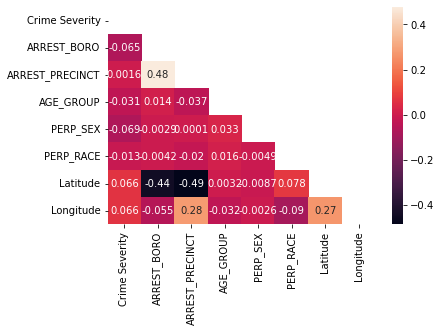

In [4]:
#Let us see a quick heat correlation map, with standardized values with ordinal plot

#Deepcopy
df2 = copy.deepcopy(df[['Crime Severity', 'ARREST_BORO', 'ARREST_PRECINCT',
                        'AGE_GROUP','PERP_SEX', 'PERP_RACE', 'Latitude', 'Longitude']])

#Apply correlation
matrix_corr = df2.corr()

#Create plot, applying mask (cut in half)
mask = np.triu(np.ones_like(matrix_corr, dtype=bool))
sns.heatmap(matrix_corr, annot=True, mask = mask)
plt.show()

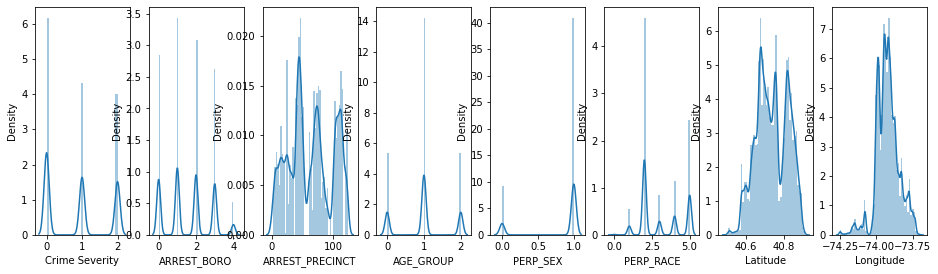

In [5]:
#Check distribution skewness

#exctract column values, identify number of columns and rows
l = df2.columns.values 
number_of_columns=8
number_of_rows = len(l)-1/number_of_columns

#plot figure for each column
plt.figure(figsize=(2*number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.distplot(df[l[i]],kde=True) 

### Specificailly looking at dates

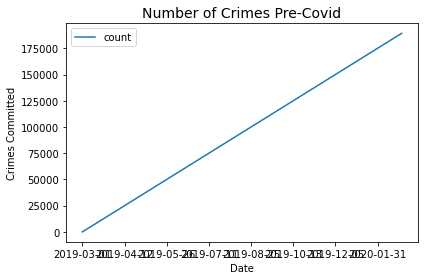

In [6]:
#Let us try plotting the datas

#Select only dates and add a count column
test = data[['ARREST_DATE']].copy()
test['count'] = 1
test.set_index('ARREST_DATE', inplace = True) #set to index

#create plot with culmulative sum
test.sort_index().cumsum().plot() 
plt.title('Number of Crimes Pre-Covid', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Crimes Committed')
plt.tight_layout()
plt.show()

#this will probably look better using month or more years

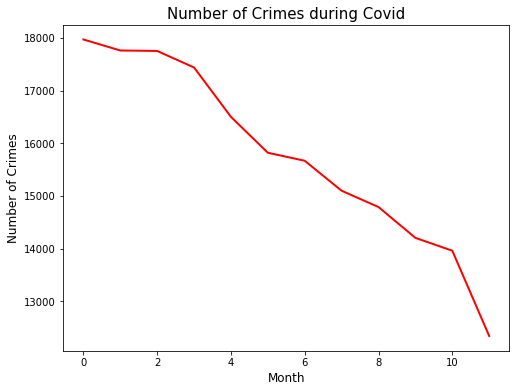

In [7]:
#Bar plot of number of offenses each Month

#month order (ie. period of time changes order)
month_order = [3,4,5,6,7,8,9,10,11,12,1,2]

#Create plot
plt.figure(figsize=[8,6])
plt.plot(data['Month'].value_counts().values, color = 'red', lw = 2) #array of y values; dates
plt.xlabel('Month', size = 12)
plt.ylabel('Number of Crimes', size = 12)
plt.title('Number of Crimes during Covid', size= 15)
plt.show()

#this plot is not 100% correct, should be reordered

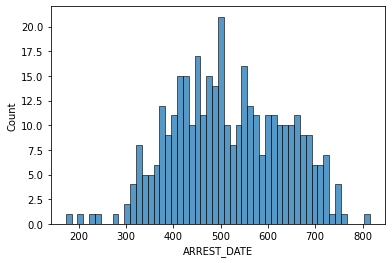

In [8]:
#A histogram showing the distribution of number of crimes over date, 52 bins=52weeks
sns.histplot(data=data, x = data['ARREST_DATE'].value_counts(), bins=52)

This is not a great histogram. There seems to be a "normal" distribution. But I will look more closely using the month and day of the week.

In [9]:
# add weekday and month into data
data['ARREST_DATE'] = pd.to_datetime(data['ARREST_DATE']) #convert column
data['Month'] = data['ARREST_DATE'].dt.month
data['WeekDay'] = data['ARREST_DATE'].dt.weekday

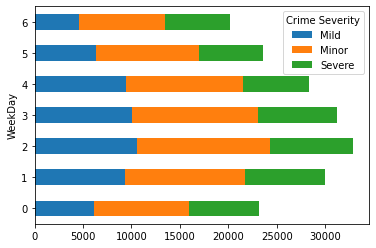

In [10]:
#Bar plot showing proportion of crimes committed per day of the week for crime severity
pd.crosstab(data['WeekDay'],data['Crime Severity']).plot(kind="barh",stacked=True)

In [11]:
#Trying some stats

#first tabulate a 2 way table with variables as days of week and level of crime
two_way_table = pd.crosstab(index=data["WeekDay"], columns=data["Crime Severity"])

#Calculate the chi-square test
result_chi = stats.chi2_contingency(observed = two_way_table)
chi2, p, dof, expected = stats.chi2_contingency(observed = two_way_table)

print('chi-square statistic :', result_chi[0]) #amount of difference btw observed counts and counts expected if no relationship (low value = high corr)
print('p-value :', result_chi[1])
print('degrees of freedom :', result_chi[2]) #max number of logicailly independent values
#print('expected counts : \n', result_chi[3])

table = sm.stats.Table(two_way_table)
table.standardized_resids

chi-square statistic : 1346.0229606695657
p-value : 6.011635557516533e-281
degrees of freedom : 12


Crime Severity,Mild,Minor,Severe
WeekDay,,,
0,-12.374803,-0.158240,12.842765
1,5.188734,-3.955548,-0.936143
2,9.984153,-3.168300,-6.715887
3,10.857434,-3.772719,-6.941264
4,13.901516,0.076627,-14.315342
5,-9.912085,7.645679,1.689479
6,-23.765721,5.000205,18.797326


In [12]:
#define function to find if p exported from stats.chi_contency is significant

def chi_significant(p):
    """
    Function to test if the p value is significant based on the Chi2 Contingency test
    """
    prob = 0.95 #confidence level
    alpha = 1.0 - prob
    print('significance=%.3f, p=%.3f' % (alpha, p))
    
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')

In [13]:
#use chi significance function
chi_significant(p)

significance=0.050, p=0.000
Dependent (reject H0)


The Chi-Square test above shows that there is a significant relationship on the dependency between crime severity and the day of the week, meaning there is a distribution of crime.

1. Monday (0) Overall less crimes happens on Monday, and crimes significnatly more likely to be severe
2. Tuesday (1) crimes are significantly more likely to be mild
3. Wednesday (2) the crimes are again significantly more likely to be mild
4. Thursday (3) the crimes are  significantly more likely to be mild
5. Friday (4) crimes most likely to happen are minor and mild, signifcantly more mild
6. Saturday (5) crimes most likely to happen are minor or severe, significantly more minor
7. Sunday (6) crimes most likely to happen are minor or severe, significantly more severe

Overall:
    
    Monday, Saturday and Sunday is when the severe crimes significantly occur.
    Tuesday to Friday is when mild crimes significantly occur compared to other crimes.
    Minor crimes are significantly more likely to occur Fri-Sunday.
    
Therefore, we could interpret possible patterns. Such as people are more likely to let loose are weekends or interact with others more that might lead to more severe crime.

In [14]:
#ANOVA needs oridinal frame, therefore add weekday columns
df['ARREST_DATE'] = pd.to_datetime(df['ARREST_DATE']) #convert column
df['Month'] = df['ARREST_DATE'].dt.month
df['WeekDay'] = df['ARREST_DATE'].dt.weekday

#perform one-way ANOVA - all our values are categorical, we would need quantitative variable for 2-way ANOVA
f_oneway(df['WeekDay'], df['Crime Severity'])

F_onewayResult(statistic=183343.71284086243, pvalue=0.0)

This shows that there is a significant relationship between the day of the week, crime severity and the borough

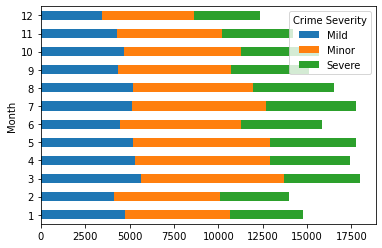

In [15]:
#Bar plot showing proportion of crimes committed crime severity level during each month
pd.crosstab(data['Month'],data['Crime Severity']).plot(kind="barh",stacked=True)

In [16]:
#first tabulate a 2 way table with variables as months and level of crime
two_way_table = pd.crosstab(index=data["Month"], columns=data["Crime Severity"])

#Calculate the chi-square test
result_chi = stats.chi2_contingency(observed = two_way_table)
chi2, p, dof, expected = stats.chi2_contingency(observed = two_way_table)

print('chi-square statistic :', result_chi[0])
print('p-value :', result_chi[1])
print('degrees of freedom :', result_chi[2])
#print('expected counts : \n', result_chi[3])

table = sm.stats.Table(two_way_table)
table.standardized_resids

chi-square statistic : 333.2846310808533
p-value : 2.055669926648505e-57
degrees of freedom : 22


Crime Severity,Mild,Minor,Severe
Month,,,
1,6.035379,-6.365151,0.862542
2,-0.771508,0.593430,0.133351
3,4.264122,6.838326,-11.929245
4,1.729993,2.983876,-5.071546
5,-1.546741,2.330103,-0.994080
6,-5.104469,2.128440,2.870932
7,-2.638002,-0.031994,2.735836
8,4.544878,-4.392557,0.206348
9,-2.782146,-1.379750,4.374208


In [17]:
#use chi significance function
chi_significant(p)

significance=0.050, p=0.000
Dependent (reject H0)


The Chi-Square test above shows that there is a significant relationship on the dependency between crime severity and the Month of the year, meaning there is a distribution of crime.

1. Jan - There are significantly more mild and severe crimes, and we see signifcantly more mild
2. Feb - Although less significant than Jan there are more minor and severe crimes
3. March - Significantly more than Feb and crimes more likely to be minor or mild, more so minor
4. April - Significantly, crimes more likely to be minor or mild
5. May - Crimes are more significantly to be Minor
6. June - Significantly, crimes more likely to be minor or severe, more so severe
7. July - Crimes are significantly more likely to be severe
8. Aug - Significantly more likely to be mild or severe, significantly more mild
9. Sept - Crimes are significantly more likely to be severe
10. Oct - Signifantly more likely to be mild or severe, not by much
11. Nov - Signifantly more likely to be mild or severe, not by much
12. Dec - Crimes are significantly more likely to be severe

Common trends we can see:

    The highest amount of severe crimes are committed in September and December, followed by June, July & November.
    The highest amount of mild crimes are committed in January, March and August.
    The minor crimes seem to be more likely to significantly occur from Feb to June
    
Therefore, we can see that prior to covid, the severe crimes started decreasing in 2020 after December 2019, and more minor or mild crimes picked up. During 2019, there was significantly more minor and mild crimes, however severe crimes still significantly occured as well

In [18]:
#perform one-way ANOVA 
f_oneway(df['Month'], df['Crime Severity'], df['ARREST_BORO'])

F_onewayResult(statistic=389187.6411643349, pvalue=0.0)

Again we see that these values are significant!

### Relations with Borough

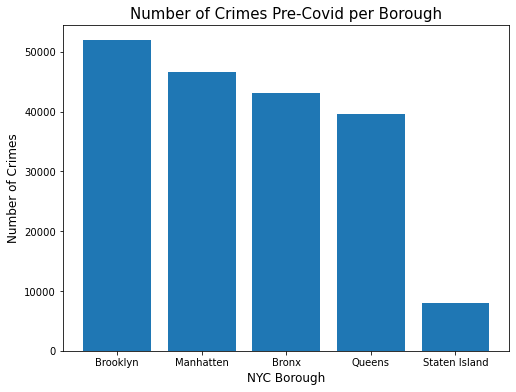

In [19]:
#Bar plot of number of offenses in each borrow
plt.figure(figsize=[8,6])
plt.bar(data['ARREST_BORO'].value_counts().index.tolist(), 
        data['ARREST_BORO'].value_counts().values)
plt.xlabel('NYC Borough', size = 12)
plt.ylabel('Number of Crimes', size = 12)
plt.title('Number of Crimes Pre-Covid per Borough', size= 15)
plt.show()

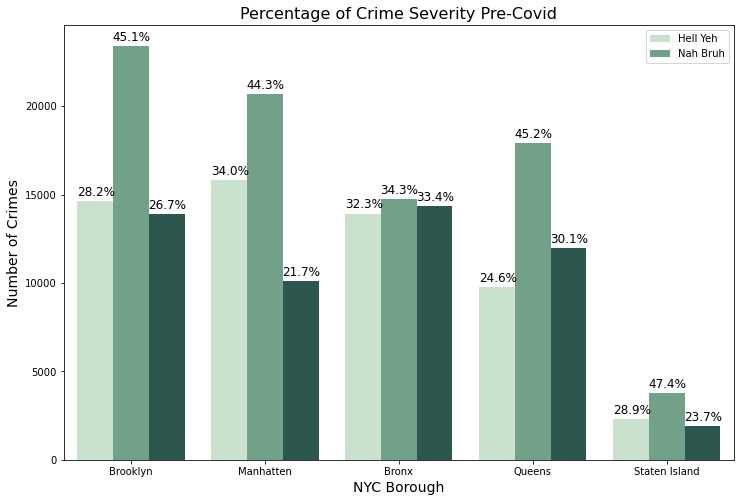

In [20]:
#Calculating the percentage of crime severity of each borough
boro_name = ['Manhatten', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']
crime_level = ['Minor', 'Mild', 'Severe']
subtotal_boro = data.groupby('ARREST_BORO')['Crime Severity'].agg('count').sort_values(ascending=False) #total of each boro count
fig = plt.figure(figsize=[12,8])
ax = sns.countplot(x="ARREST_BORO", hue="Crime Severity", 
                   data=data[['ARREST_BORO', 'Crime Severity']], 
                   order = subtotal_boro.index,
                  palette = "ch:2.5,-.2,dark=.3")
ax.set_xlabel('NYC Borough', fontsize = 14)
ax.set_ylabel('Number of Crimes', fontsize = 14)
ax.set_title('Percentage of Crime Severity Pre-Covid', fontsize = 16)
ax.legend(labels=['Hell Yeh', 'Nah Bruh'])

#calculate percentage to anntotate
boro_num2 = [val for val in range(0, 5)]*3 #[0,1,2,3,4,0,1,2,3,4...] work for the order
for p, i in zip(ax.patches, boro_num2):
    percent = p.get_height()/subtotal_boro[i]
    ax.annotate('{:.1f}%'. format(percent*100), (p.get_x()+0.138, p.get_height()+300), 
                ha='center', size=12)
    
fig = ax.get_figure()
fig.savefig('Figures/Crime_Severity_Pre_Covid.png')

In [21]:
#Lets look at this more closey
two_way_table = pd.crosstab(index=data["ARREST_BORO"], columns=data["Crime Severity"])

#Calculate the chi-square test
result_chi = stats.chi2_contingency(observed = two_way_table)
chi2, p, dof, expected = stats.chi2_contingency(observed = two_way_table)

print('chi-square statistic :', result_chi[0])
print('p-value :', result_chi[1])
print('degrees of freedom :', result_chi[2])
#print('expected counts : \n', result_chi[3])

table = sm.stats.Table(two_way_table)
table.standardized_resids

chi-square statistic : 2936.5211484101965
p-value : 0.0
degrees of freedom : 8


Crime Severity,Mild,Minor,Severe
ARREST_BORO,,,
Bronx,12.917435,-39.558231,30.533968
Brooklyn,-9.695897,13.596428,-5.114223
Manhatten,22.339297,8.913787,-32.728043
Queens,-25.433907,11.975410,12.789406
Staten Island,-1.809500,8.957668,-8.056155


In [22]:
#use chi significance function
chi_significant(p)

significance=0.050, p=0.000
Dependent (reject H0)


The Chi-Square test above shows that there is a significant relationship on the dependency between crime severity and the NYC Borough, meaning there is a distribution of crime.

1. Bronx (0) - Crimes are more likely to be mild or severe, sig more severe
2. Brooklyn (1) - Crimes are significantly more likely to be minor
3. Manhatten (2) - Crimes are significantly more likely to be minor or mild, sig more mild
4. Queens (3) - Crimes are significantly more likely to be minor or severe
5. Staten Island (4) - Crimes are more significantly to be minor

Common trends we can see:

    Crime are signifcantly more likely to be minor (except in the Bronx). With mild crimes significantly more likely to occur in the Bronc and Manhatten. While severe crime is significantly more likly to occur in the Bronx and Queens

In [23]:
#perform one-way ANOVA 
f_oneway(df['ARREST_BORO'], df['Crime Severity'], df['ARREST_PRECINCT']) #precinct column only in df

F_onewayResult(statistic=590116.0572474473, pvalue=0.0)

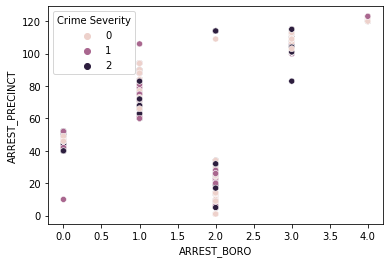

In [24]:
#plot showing crime severity when arrest precinct and boro are plotted together
sns.scatterplot(data=df, x=df.ARREST_BORO, y=df.ARREST_PRECINCT, hue =df['Crime Severity'])

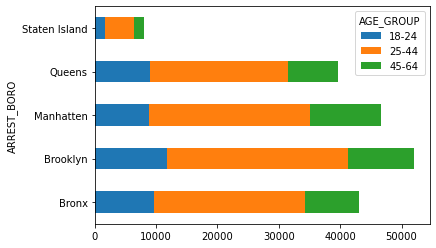

In [25]:
#Bar plot showing proportion of crimes committed per age group at each boro
pd.crosstab(data['ARREST_BORO'], data['AGE_GROUP']).plot(kind="barh",stacked=True)

In [26]:
#Lets do the same stats but with ARREST BORO and age group
two_way_table = pd.crosstab(index=data["ARREST_BORO"], columns=data["AGE_GROUP"])

#Calculate the chi-square test
result_chi = stats.chi2_contingency(observed = two_way_table)
chi2, p, dof, expected = stats.chi2_contingency(observed = two_way_table)

print('chi-square statistic :', result_chi[0])
print('p-value :', result_chi[1])
print('degrees of freedom :', result_chi[2])
#print('expected counts : \n', result_chi[3])

table = sm.stats.Table(two_way_table)
table.standardized_resids

chi-square statistic : 526.5453914260033
p-value : 1.413010378760466e-108
degrees of freedom : 8


AGE_GROUP,18-24,25-44,45-64
ARREST_BORO,,,
Bronx,5.684731,1.084128,-7.003290
Brooklyn,6.292011,-0.311555,-5.929096
Manhatten,-16.947499,-1.771434,19.117457
Queens,5.848536,-0.090846,-5.750822
Staten Island,-1.334351,2.412593,-1.571687


In [27]:
#use chi significance function
chi_significant(p)

significance=0.050, p=0.000
Dependent (reject H0)


The Chi-Square test above shows that there is a significant relationship on the dependency between crime severity and the Month of the year, meaning there is a distribution of crime.

1. Bronx (0) - Crimes are more likely to occur in the 18-24 and the 25-44 age groups, sig more in 18-24
2. Brooklyn (1) - Crimes are significantly more likely to be committed byt the 18-24 age group
3. Manhatten (2) - Crimes are significantly more likely to be committed by the 45 to 64 age group
4. Queens (3) - Crimes are significantly more likely to be committed by the 18-24 age group
5. Staten Island (4) - Crimes are more significantly to be committed by the 24-44 age group

Common trends we can see:

    The 18-24 age group are more likely to commit crimes in 3/5 boroughs. While the 45 to 64 age group are more likely to do crime in Manhatten.  And the 25-44 more likely to commit crime in the Bronx and Staten Island

In [28]:
#perform one-way ANOVA 
f_oneway(df['ARREST_BORO'], df['AGE_GROUP'], df['PERP_RACE'])

F_onewayResult(statistic=169905.29221649547, pvalue=0.0)

Yes we have signifcance in the boroughs with our demographics

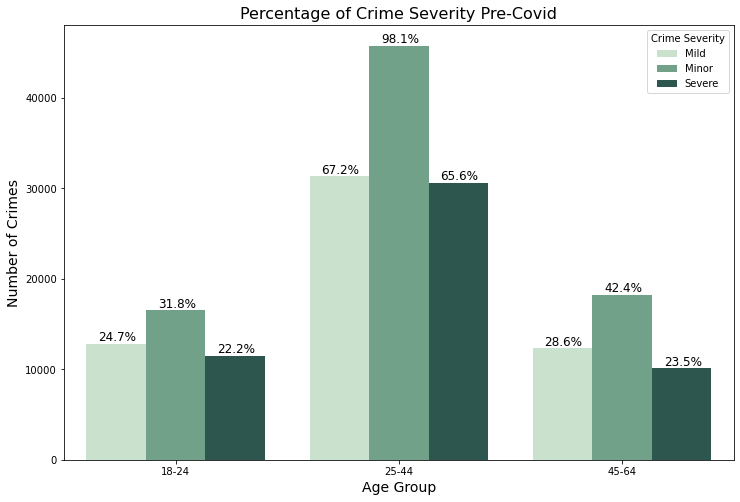

In [29]:
#Calculating the percentage of crime severity of each age group
age_name = ['18-24', '25-44', '45-64']
crime_level = ['Minor', 'Mild', 'Severe']
subtotal_age = data.groupby('AGE_GROUP')['Crime Severity'].agg('count').sort_values(ascending=False) #total of each boro count
fig = plt.figure(figsize=[12,8])
ax = sns.countplot(x="AGE_GROUP", hue="Crime Severity", 
                   data=data[['AGE_GROUP', 'Crime Severity']], 
                   order = age_name,
                  palette = "ch:2.5,-.2,dark=.3")
ax.set_xlabel('Age Group', fontsize = 14)
ax.set_ylabel('Number of Crimes', fontsize = 14)
ax.set_title('Percentage of Crime Severity Pre-Covid', fontsize = 16)

#calculate percentage to anntotate
age_name2 = [val for val in range(0,3)]*3 #[0,1,2,3,4,0,1,2,3,4...] work for the order
for p, i in zip(ax.patches, age_name2):
    percent = p.get_height()/subtotal_boro[i]
    ax.annotate('{:.1f}%'. format(percent*100), (p.get_x()+0.138, p.get_height()+300), 
                ha='center', size=12)
    
fig = ax.get_figure()
fig.savefig('Figures/Crime_Severity_Pre_Covid_Age.png')

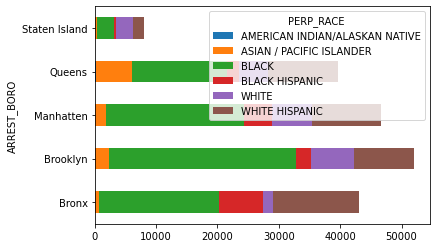

In [30]:
#Bar plot showing proportion of crimes committed per race at each boro
pd.crosstab(data['ARREST_BORO'], data['PERP_RACE']).plot(kind="barh",stacked=True)

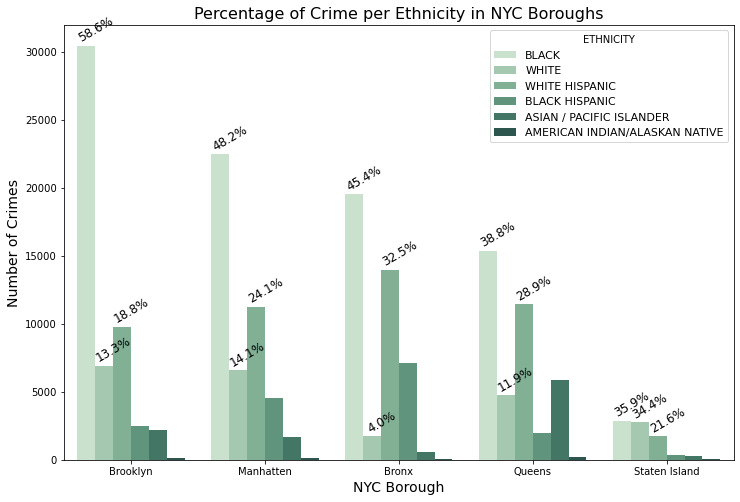

In [31]:
#Calculating the percentage of crimes by ethnicity at each borough
boro_name = ['Manhatten', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']
race = ['AMERICAN INDIAN/ALASKAN NATIVE', 'ASIAN / PACIFIC ISLANDER', 
        'BLACK', 'BLACK HISPANIC', 'WHITE','WHITE HISPANIC']
subtotal_boro = data.groupby('ARREST_BORO')['PERP_RACE'].agg('count').sort_values(ascending=False) #total of each boro count
fig = plt.figure(figsize=[12,8])
ax = sns.countplot(x="ARREST_BORO", hue="PERP_RACE", 
                   data=data[['ARREST_BORO', 'PERP_RACE']], 
                   order = subtotal_boro.index,
                  palette = "ch:2.5,-.2,dark=.3")

ax.set_xlabel('NYC Borough', fontsize = 14)
ax.set_ylabel('Number of Crimes', fontsize = 14)
ax.set_title('Percentage of Crime per Ethnicity in NYC Boroughs', fontsize = 16)
ax.legend(title = "ETHNICITY", fontsize = 11)

#calculate percentage to anntotate
boro_num2 = [val for val in range(0, 5)]*3 #[0,1,2,3,4,0,1,2,3,4...] work for the order
for p, i in zip(ax.patches, boro_num2):
    percent = p.get_height()/subtotal_boro[i]
    ax.annotate('{:.1f}%'. format(percent*100), (p.get_x()+0.138, p.get_height()+300), 
                ha='center', size=12, rotation = 30)

In [32]:
#Lets do the same stats but with ARREST BORO and race
two_way_table = pd.crosstab(index=data["ARREST_BORO"], columns=data["PERP_RACE"])

#Calculate the chi-square test
result_chi = stats.chi2_contingency(observed = two_way_table)
chi2, p, dof, expected = stats.chi2_contingency(observed = two_way_table)

print('chi-square statistic :', result_chi[0])
print('p-value :', result_chi[1])
print('degrees of freedom :', result_chi[2])
#print('expected counts : \n', result_chi[3])

table = sm.stats.Table(two_way_table)
table.standardized_resids

chi-square statistic : 23025.560807982594
p-value : 0.0
degrees of freedom : 20


PERP_RACE,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,WHITE,WHITE HISPANIC
ARREST_BORO,,,,,,
Bronx,-4.734544,-43.545938,-12.041202,66.012810,-57.997725,37.935689
Brooklyn,-4.222415,-16.681008,57.235041,-36.748694,10.990684,-40.713815
Manhatten,-1.556901,-21.484260,1.369612,8.650752,16.176638,-7.693573
Queens,10.311580,89.739954,-40.927222,-29.356276,-0.555603,17.663167
Staten Island,1.709474,-7.781522,-22.039500,-15.191483,63.005555,-7.989777


In [33]:
#use chi significance function
chi_significant(p)

significance=0.050, p=0.000
Dependent (reject H0)


The Chi-Square test above shows that there is a significant relationship on the dependency between crime severity and the Month of the year, meaning there is a distribution of crime.

1. Bronx (0) - Crimes are more likely to be committed by Black Hispanic and White Hispanics
2. Brooklyn (1) - Crimes are significantly more likely to be committed by Black and White, sig more Black
3. Manhatten (2) - Crimes are significantly more likely to be committed by Black, Black Hispanic & White, Sig more white
4. Queens (3) - Crimes are significantly more likely to be committed by Indigenious, Asian and white hispanic, sig more Asian
5. Staten Island (4) - Crimes are more significantly to be committed by Indigenious and whites, sig more whites

Common trends we can see:

    Trends may be tied more to economics. Queens and Staten are more expensive, so more likely to occur by Asian & Whites.

#### Relations with Crime Severity

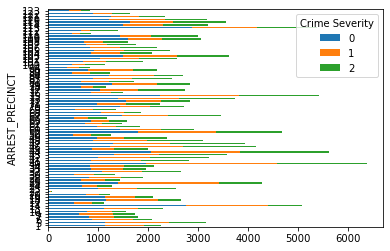

In [34]:
#Bar plot showing proportion of crimes committed per crime severity level at each precinct
pd.crosstab(df['ARREST_PRECINCT'], df['Crime Severity']).plot(kind="barh",stacked=True)

This is messy, let me look more closely by borough

In [35]:
#Seperate data into boroughs
Bronx = df.loc[df['ARREST_BORO'] == 0]
Brooklyn = df.loc[df['ARREST_BORO'] == 1]
Manhatten = df.loc[df['ARREST_BORO'] == 2]
Queens = df.loc[df['ARREST_BORO'] == 3]
Staten = df.loc[df['ARREST_BORO'] == 4]

Now do each precinct in each borough

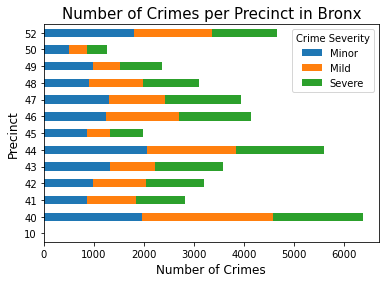

In [36]:
#plot Precints in Bronx with crime severity
pd.crosstab(Bronx['ARREST_PRECINCT'], 
            Bronx['Crime Severity']).plot(kind="barh",stacked=True)
plt.xlabel('Number of Crimes', size = 12)
plt.ylabel('Precinct', size = 12)
plt.title('Number of Crimes per Precinct in Bronx', size= 15)
plt.legend(['Minor','Mild','Severe'], title = 'Crime Severity')
plt.show()

In [37]:
#Lets do the same stats but with the precincts in the Bronx and crime severity
two_way_table = pd.crosstab(index=Bronx["Crime Severity"], columns=Bronx["ARREST_PRECINCT"])

#Calculate the chi-square test
result_chi = stats.chi2_contingency(observed = two_way_table)
chi2, p, dof, expected = stats.chi2_contingency(observed = two_way_table)

print('chi-square statistic :', result_chi[0])
print('p-value :', result_chi[1])
print('degrees of freedom :', result_chi[2])
#print('expected counts : \n', result_chi[3])

table = sm.stats.Table(two_way_table)
table.standardized_resids

chi-square statistic : 775.7892587590409
p-value : 2.6709083468234447e-148
degrees of freedom : 24


ARREST_PRECINCT,10,40,41,42,43,44,45,46,47,48,49,50,52
Crime Severity,,,,,,,,,,,,,
0,-0.276433,-6.703838,-4.131449,-4.380597,3.160051,4.032312,9.026644,-6.119422,-1.708542,-6.206505,7.195634,3.823716,6.580102
1,0.533706,16.431655,3.075128,0.810394,-9.295280,-1.069568,-9.329404,3.989963,-5.235311,3.106301,-10.145787,-2.827429,1.251393
2,-0.251214,-9.553059,1.107820,3.605278,6.040500,-2.997609,0.169435,2.201236,6.913287,3.165506,2.822283,-1.043800,-7.864506


#### Note
This is an example of how we can select our Precincts.

If we just want to focus on severe crime then in the Bronx maybe precincts 42, 43, 47 and 48 could be something to look at.

Or we can go based on the bar plot and select precincts based on crime count.

In [38]:
#perform one-way ANOVA 
f_oneway(Bronx['ARREST_PRECINCT'], Bronx['Crime Severity']) #significant difference between precincts with crime severity

F_onewayResult(statistic=5731345.993682817, pvalue=0.0)

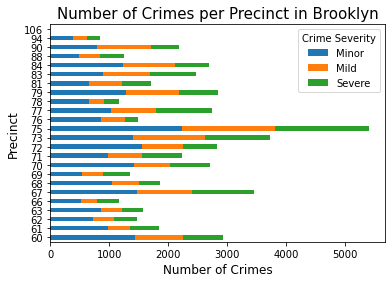

In [39]:
#plot Precints in Brooklyn with crime severity
pd.crosstab(Brooklyn['ARREST_PRECINCT'], 
            Brooklyn['Crime Severity']).plot(kind="barh",stacked=True)
plt.xlabel('Number of Crimes', size = 12)
plt.ylabel('Precinct', size = 12)
plt.title('Number of Crimes per Precinct in Brooklyn', size= 15)
plt.legend(['Minor','Mild','Severe'], title = 'Crime Severity')
plt.show()

In [40]:
#perform one-way ANOVA 
f_oneway(Brooklyn['ARREST_PRECINCT'], Brooklyn['Crime Severity']) #significant difference between precincts with crime severity

F_onewayResult(statistic=4032569.478927156, pvalue=0.0)

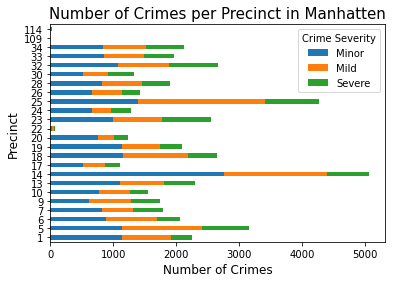

In [41]:
#plot Precints in Manhatten with crime severity
pd.crosstab(Manhatten['ARREST_PRECINCT'], 
            Manhatten['Crime Severity']).plot(kind="barh",stacked=True)
plt.xlabel('Number of Crimes', size = 12)
plt.ylabel('Precinct', size = 12)
plt.title('Number of Crimes per Precinct in Manhatten', size= 15)
plt.legend(['Minor','Mild','Severe'], title = 'Crime Severity')
plt.show()

In [42]:
#perform one-way ANOVA 
f_oneway(Manhatten['ARREST_PRECINCT'], Manhatten['Crime Severity']) #significant difference between precincts with crime severity

F_onewayResult(statistic=146247.2701721074, pvalue=0.0)

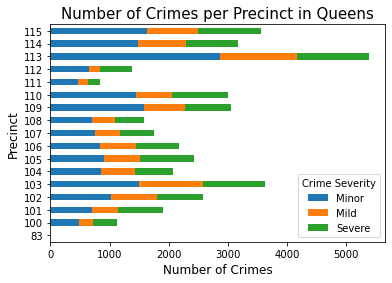

In [43]:
#plot Precints in Queens with crime severity
pd.crosstab(Queens['ARREST_PRECINCT'], 
            Queens['Crime Severity']).plot(kind="barh",stacked=True)
plt.xlabel('Number of Crimes', size = 12)
plt.ylabel('Precinct', size = 12)
plt.title('Number of Crimes per Precinct in Queens', size= 15)
plt.legend(['Minor','Mild','Severe'], title = 'Crime Severity')
plt.show()

In [44]:
#perform one-way ANOVA 
f_oneway(Queens['ARREST_PRECINCT'], Queens['Crime Severity']) #significant difference between precincts with crime severity

F_onewayResult(statistic=19950318.090575423, pvalue=0.0)

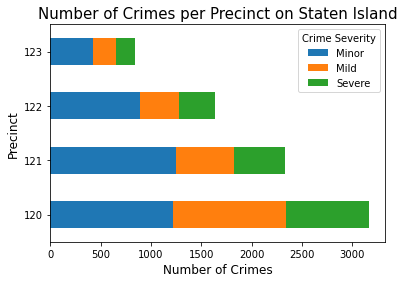

In [45]:
#plot Precints on Staten Island with crime severity
pd.crosstab(Staten['ARREST_PRECINCT'], 
            Staten['Crime Severity']).plot(kind="barh",stacked=True)
plt.xlabel('Number of Crimes', size = 12)
plt.ylabel('Precinct', size = 12)
plt.title('Number of Crimes per Precinct on Staten Island', size= 15)
plt.legend(['Minor','Mild','Severe'], title = 'Crime Severity')
plt.show()

In [46]:
#perform one-way ANOVA 
f_oneway(Staten['ARREST_PRECINCT'], Staten['Crime Severity']) #significant difference between precincts with crime severity

F_onewayResult(statistic=68842857.73942314, pvalue=0.0)

In all boroughs, there is a significant difference with the number of crimes per precinct and crime severity

### Relations with demographic factors

We aren't focusing too much on demographics for this assignment, so I will just do some basic one-way ANOVAS

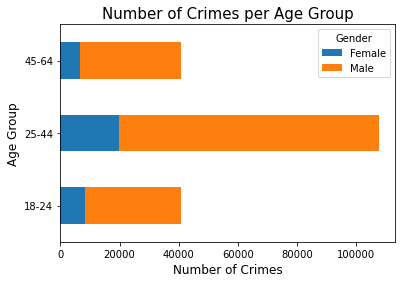

In [47]:
#plot gender by Age group
pd.crosstab(data['AGE_GROUP'], 
            data['PERP_SEX']).plot(kind="barh",stacked=True)
plt.xlabel('Number of Crimes', size = 12)
plt.ylabel('Age Group', size = 12)
plt.title('Number of Crimes per Age Group', size= 15)
plt.legend(['Female','Male'], title = 'Gender')
plt.show()

In [48]:
#perform one-way ANOVA 
f_oneway(df['AGE_GROUP'], df['PERP_SEX']) #significant difference between age and sex

F_onewayResult(statistic=10775.15228867766, pvalue=0.0)

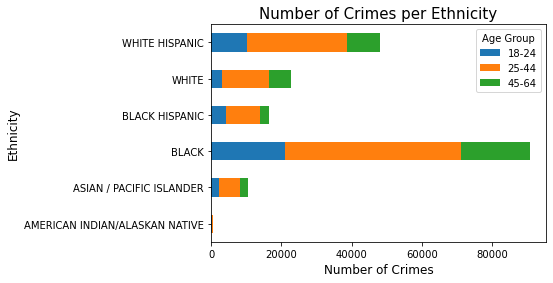

In [49]:
#plot ethnicity by sex
pd.crosstab(data['PERP_RACE'], 
            data['AGE_GROUP']).plot(kind="barh",stacked=True)
plt.xlabel('Number of Crimes', size = 12)
plt.ylabel('Ethnicity', size = 12)
plt.title('Number of Crimes per Ethnicity', size= 15)
plt.legend(['18-24','25-44','45-64'], title = 'Age Group')
plt.show()

In [50]:
#perform one-way ANOVA 
f_oneway(df['AGE_GROUP'], df['PERP_RACE']) #significant difference between age and race

F_onewayResult(statistic=339689.02217587846, pvalue=0.0)

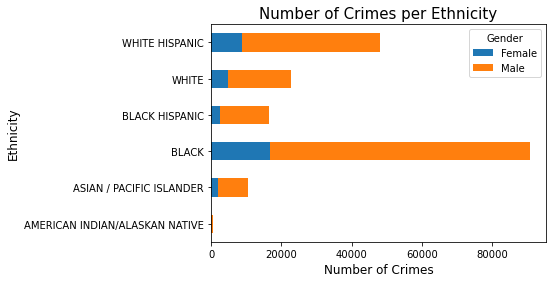

In [51]:
#plot ethnicity by sex
pd.crosstab(data['PERP_RACE'], 
            data['PERP_SEX']).plot(kind="barh",stacked=True)
plt.xlabel('Number of Crimes', size = 12)
plt.ylabel('Ethnicity', size = 12)
plt.title('Number of Crimes per Ethnicity', size= 15)
plt.legend(['Female','Male'], title = 'Gender')
plt.show()

In [52]:
#perform one-way ANOVA 
f_oneway(df['PERP_RACE'], df['PERP_SEX']) #significant difference between race and sex

F_onewayResult(statistic=459529.2958497528, pvalue=0.0)

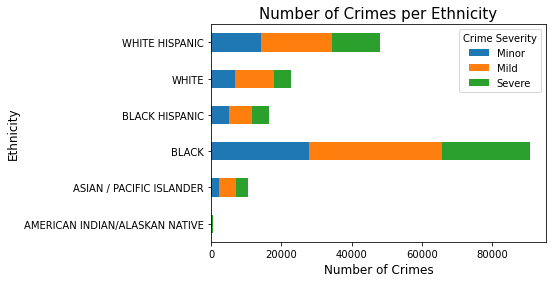

In [53]:
#plot ethnicity by crime severity
pd.crosstab(data['PERP_RACE'], 
            data['Crime Severity']).plot(kind="barh",stacked=True)
plt.xlabel('Number of Crimes', size = 12)
plt.ylabel('Ethnicity', size = 12)
plt.title('Number of Crimes per Ethnicity', size= 15)
plt.legend(['Minor','Mild','Severe'], title = 'Crime Severity')
plt.show()

In [54]:
#perform one-way ANOVA 
f_oneway(df['PERP_RACE'], df['Crime Severity']) #significant difference between race and crime severity

F_onewayResult(statistic=353046.18824348395, pvalue=0.0)

# Additional heatmap plots for temporal analysis

In [55]:
#import precovid and covid master dataframe
crime = pd.read_csv('Data/Crime_data/Other/crime_master_2.csv')
crime.head()

,ARREST_DATE,WeekDay,Month,Crime Severity,ARREST_BORO,ARREST_PRECINCT,AGE_GROUP,PERP_SEX,PERP_RACE,Latitude,Longitude,New Georeferenced Column
0,2019-03-01,4,3,1,3,114,1,1,2,40.770267,-73.915857,POINT (-73.91585715599996 40.770267001000036)
1,2019-03-01,4,3,1,0,44,1,1,2,40.836266,-73.911329,POINT (-73.91132866299995 40.83626606400003)
2,2019-03-01,4,3,1,2,18,2,1,5,40.768899,-73.982095,POINT (-73.98209493899998 40.76889926000007)
3,2019-03-01,4,3,0,2,25,1,1,3,40.798601,-73.933519,POINT (-73.93351914299996 40.79860146500005)
4,2019-03-01,4,3,1,2,23,1,1,5,40.797872,-73.944117,POINT (-73.94411676299995 40.797871503000074)


In [56]:
#turn arrest date into datetime, extract week and year and add a new column with 1
crime['ARREST_DATE'] = pd.to_datetime(crime['ARREST_DATE']) #convert column
crime['Year'] = crime['ARREST_DATE'].dt.year
crime['Week'] = crime['ARREST_DATE'].dt.isocalendar().week
crime['Count'] = 1

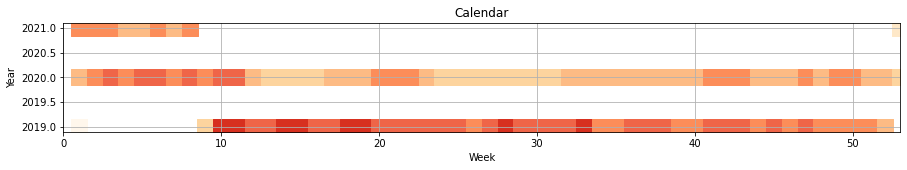

In [57]:
#Group by function and save to new variable
crime_week_year = crime.groupby(['Year','Week'])['Count'].sum().reset_index()

# Color palette
palette = ['#fff7ec','#fee8c8','#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#b30000','#7f0000']

# Assign color by count
# Set up normalise parameter
count_mean = crime_week_year.Count.mean()
std = crime_week_year.Count.std()

no = (len(palette)-1)
crime_week_year['ColorID'] =(((crime_week_year.Count -count_mean)/std))
crime_week_year['ColorID'] = np.ceil((crime_week_year['ColorID']+abs(crime_week_year['ColorID'].min()))/no*10).astype('int64')
crime_week_year.ColorID.unique()

Color=[]

for id in crime_week_year.ColorID:
    Color.append(palette[id])
    
crime_week_year['Color'] = Color


# Plot heatmap by total count (year Vs. Week)
fig=plt.figure(figsize=(15,2))
plt.xlabel('Week')
plt.ylabel('Year')
plt.title('Calendar')
colors = [(0,0,0)]

for id,row in crime_week_year.iterrows():
    plt.scatter(row['Week'],row['Year'],alpha = 1, s=250, marker='s',c=row['Color'])

plt.xlim([0,crime_week_year.Week.max()])
plt.grid()
    
#plt.show()   
#fig.savefig('Fig\TemporalHeatmap_Week_Year_byValue.jpg')

#fc8d59    5
#7f0000    4
#d7301f    4
#b30000    3
#fdbb84    3
#fee8c8    2
#ef6548    1
#fff7ec    1
#fdd49e    1
Name: Color, dtype: int64


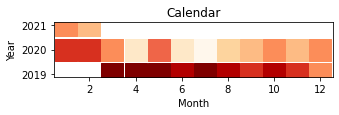

In [58]:
#Group by function and save to new variable
crime_month_year = crime.groupby(['Year','Month'])['Count'].sum().reset_index()

# Assign color by count
palette = ['#fff7ec','#fee8c8','#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#b30000','#7f0000']
no=(len(palette)-1)
crime_month_year['ColorID'] = np.ceil((crime_month_year.Count - crime_month_year.Count.min())/((crime_month_year.Count.max()-crime_month_year.Count.min())/no)).astype('int64')
Color=[]
for id in crime_month_year.ColorID:
    Color.append(palette[id])
crime_month_year['Color'] = Color

print(crime_month_year.Color.value_counts())

# Plot heatmap by total count (year Vs. Month)
fig = plt.figure(figsize=(5,1))
plt.xlabel('Month')
plt.ylabel('Year')
plt.title('Calendar')
colors = [(0,0,0)]

for id,row in crime_month_year.iterrows():
    plt.scatter(row['Month'],row['Year'],alpha = 1, s=450, marker='s',c=row['Color'])

plt.yticks([2019,2020, 2021])
plt.show() 

#figure = fig.get_figure()
fig.savefig('Figures/Month_HeatMap.png')

In [59]:
#from folium.plugins import HeatMap, MarkerCluster
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
# Since the pattern is not clear enough, try K-mean clustering to categorize the pattern
counts_columns = ['Count']
wd_counts=crime_week_year.loc[:,counts_columns]

scaler = MinMaxScaler()
wd_counts_scaled=scaler.fit_transform(wd_counts)

K = 6 # Change this value to experiment with different numbers of clusters
kmeans_wd = KMeans(n_clusters=K, random_state=10)

# Fitting the algorithm to the data
kmeans_wd = kmeans_wd.fit(wd_counts_scaled)

# Getting the Cluster labels for the dataframe
labels = kmeans_wd.predict(wd_counts_scaled)

clust_id_col_name='Clusterid'
crime_week_year[clust_id_col_name]=labels

# Gettinc cluster sizes
cluster_sizes = crime_week_year['Clusterid'].value_counts().rename_axis('Cluster id').to_frame('counts')
print("Cluster sizes:")
print(cluster_sizes)

max_cluster_size=cluster_sizes['counts'].max()
print("max = ",max_cluster_size)

# Getting the Centroid values
centroids = kmeans_wd.cluster_centers_

print("\nCluster centroids:")
print(centroids)


Cluster sizes:
            counts
Cluster id        
0               28
4               25
3               22
2               16
1               14
5                2
max =  28

Cluster centroids:
[[0.90930701]
 [0.26399665]
 [0.61518237]
 [0.75142802]
 [0.47481363]
 [0.06562833]]


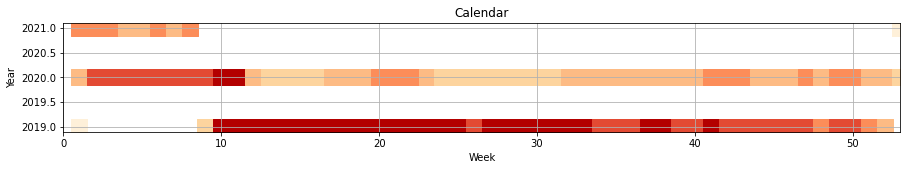

    Clusterid    Color
0           5  #fef0d9
1           1  #fdd49e
2           0  #b30000
18          3  #e34a33
40          2  #fc8d59
44          4  #fdbb84


In [60]:
centroids_list = []
palette = ['#fef0d9','#fdd49e','#fdbb84','#fc8d59','#e34a33','#b30000']

# Color the palette by the centroids' value
for k in centroids:
    centroids_list.append(k[0])
    
centroids_list_sort = sorted(centroids_list)
i=0
centroids_dict = {}
for k in centroids:
    centroids_dict[i]=k[0]
    i=i+1

mapping = dict(zip(centroids_list_sort,palette))

for key, item in centroids_dict.items():
    for k, i in mapping.items():
        if item == k:
            centroids_dict[key] = i
            
crime_week_year['Color'] = crime_week_year.Clusterid.map(centroids_dict)


# Plot graph by Year Vs. Week
fig = plt.figure(figsize=(15,2),frameon=False)
plt.xlabel('Week')
plt.ylabel('Year')
plt.title('Calendar')
colors = [(0,0,0)]

for id,row in crime_week_year.iterrows():
    plt.scatter(row['Week'],row['Year'],alpha = 1, s=250, marker='s',c=row['Color'])

plt.xlim([0,crime_week_year.Week.max()])

plt.grid(b=True,which='both')
    
plt.show()  
print(crime_week_year[['Clusterid','Color']].drop_duplicates(keep='first'))
#fig.savefig('Fig\TemporalHeatmap_Week_Year_byCluster')

### Trying a month vs crime severity plot

In [61]:
month = copy.deepcopy(data)

month = month.replace({"Month" : {1: "Jan", 2:"Feb", 3:"Mar",4:"Apr", 5:"May", 6:"Jun",
                                  7: "Jul", 8: "Aug", 9:"Sept", 10:"Oct",11:"Nov", 12:"Dec"}
                          })

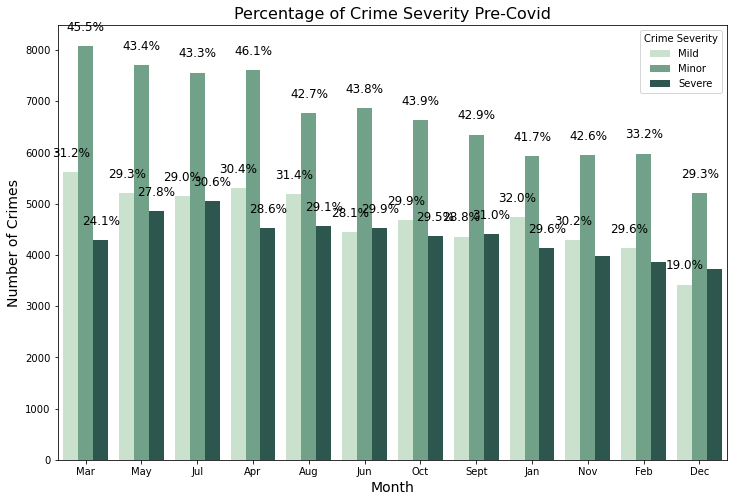

In [62]:
#Calculating the percentage of crime severity of each month
month_num = ['Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Dec','Jan','Feb']
crime_level = ['Minor', 'Mild', 'Severe']
subtotal_month = month.groupby('Month')['Crime Severity'].agg('count').sort_values(ascending=False) #total of each boro count
fig = plt.figure(figsize=[12,8])
ax = sns.countplot(x="Month", hue="Crime Severity", 
                   data=month[['Month', 'Crime Severity']],

                   order = subtotal_month.index,
                  palette = "ch:2.5,-.2,dark=.3")
ax.set_xlabel('Month', fontsize = 14)
ax.set_ylabel('Number of Crimes', fontsize = 14)
ax.set_title('Percentage of Crime Severity Pre-Covid', fontsize = 16)

#calculate percentage to anntotate
month_num2 = [val for val in range(0, 11)]*3 #[0,1,2,3,4,0,1,2,3,4...] work for the order
for p, i in zip(ax.patches, month_num2):
    percent = p.get_height()/subtotal_month[i]
    ax.annotate('{:.1f}%'. format(percent*100), (p.get_x()+0.138, p.get_height()+300), 
                ha='center', size=12)
    
#fig = ax.get_figure()
#fig.savefig('Figures/Crime_Severity_Pre_Covid.png')

Very poor plot, let us see value counts

In [63]:
#Create new variable using group by and get value counts for each type
month_crime = month.groupby('Month')['Crime Severity'].value_counts()
#create other varian;e calculting the grouped proportions
month_crime = month_crime.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
month_crime

Month  Crime Severity
Apr    Minor             43.626355
       Mild              30.414588
       Severe            25.959057
Aug    Minor             40.946552
       Mild              31.390135
       Severe            27.663314
Dec    Minor             42.103557
       Severe            30.192043
       Mild              27.704400
Feb    Minor             42.800860
       Mild              29.555874
       Severe            27.643266
Jan    Minor             40.077084
       Mild              32.023801
       Severe            27.899114
Jul    Minor             42.550555
       Mild              28.981017
       Severe            28.468428
Jun    Minor             43.362832
       Severe            28.571429
       Mild              28.065740
Mar    Minor             44.961327
       Mild              31.228090
       Severe            23.810584
May    Minor             43.384754
       Mild              29.337912
       Severe            27.277334
Nov    Minor             41.83328